In [1]:
import pandas as pd
import numpy as np
import matplotlib as plt
import collections
from pathlib import Path
from tqdm.auto import tqdm

import math
%pylab inline
%reload_ext autoreload
%autoreload 2


Populating the interactive namespace from numpy and matplotlib


/home/wassname/.pyenv/versions/3.7.2/envs/jup3.7.2/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['plt']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
import logging
logging.basicConfig(stream=sys.stdout, level=logging.INFO)
logger = logging.getLogger("smartmeters.ipynb")

In [3]:
import torch
from torch import nn
import torch.nn.functional as F

In [4]:
from src.models.model import LatentModel
from src.data.smart_meter import collate_fns, SmartMeterDataSet

In [5]:
# Params
device='cuda'
batch_size=32
num_workers=5
use_logy=False
num_context, num_extra_target = 24*2*3, 24*2
esp=1e-4

# Load kaggle smart meter data

In [6]:
csv_files = sorted(Path('data/smart-meters-in-london/halfhourly_dataset').glob('*.csv'))[:1]
df = pd.concat([pd.read_csv(f, parse_dates=[1], na_values=['Null']) for f in tqdm(csv_files)])
print(df.info())

df = df.groupby('tstp').mean()
df['tstp'] = df.index
df.index.name = ''
df.head(3)




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1222670 entries, 0 to 1222669
Data columns (total 3 columns):
LCLid             1222670 non-null object
tstp              1222670 non-null datetime64[ns]
energy(kWh/hh)    1222620 non-null float64
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 28.0+ MB
None


,energy(kWh/hh),tstp
,,
2011-12-03 09:00:00,0.149,2011-12-03 09:00:00
2011-12-03 09:30:00,0.154,2011-12-03 09:30:00
2011-12-03 10:00:00,0.768,2011-12-03 10:00:00


In [7]:
# Load weather data
df_weather = pd.read_csv('data/smart-meters-in-london/weather_hourly_darksky.csv', parse_dates=[3])

use_cols = ['visibility', 'windBearing', 'temperature', 'time', 'dewPoint',
       'pressure', 'apparentTemperature', 'windSpeed', 
       'humidity']
df_weather = df_weather[use_cols].set_index('time')

# Resample to match energy data    
df_weather = df_weather.resample('30T').ffill()

# Normalise
weather_norms=dict(mean={'visibility': 11.2,
 'windBearing': 195.7,
 'temperature': 10.5,
 'dewPoint': 6.5,
 'pressure': 1014.1,
 'apparentTemperature': 9.2,
 'windSpeed': 3.9,
 'humidity': 0.8},
std={'visibility': 3.1,
 'windBearing': 90.6,
 'temperature': 5.8,
 'dewPoint': 5.0,
 'pressure': 11.4,
 'apparentTemperature': 6.9,
 'windSpeed': 2.0,
 'humidity': 0.1})

for col in df_weather.columns:
    df_weather[col] -= weather_norms['mean'][col]
    df_weather[col] /= weather_norms['std'][col]

    
print(len(df))
df = pd.concat([df, df_weather], 1).dropna()
len(df)

39292


39225

In [8]:
# Also find bank holidays
df_hols = pd.read_csv('./data/smart-meters-in-london/uk_bank_holidays.csv', parse_dates=[0])
holidays = set(df_hols['Bank holidays'].dt.round('D'))

df['holiday'] = df.tstp.apply(lambda dt:dt.floor('D') in holidays).astype(int)

In [9]:
# Add time features
time = df.tstp
df["month"] = time.dt.month / 12.0
df['day'] = time.dt.day / 310.0
df['week'] = time.dt.week / 52.0
df['hour'] = time.dt.hour / 24.0
df['minute'] = time.dt.minute / 24.0
df['dayofweek'] = time.dt.dayofweek / 7.0

In [10]:
# Drop nan and 0's
df = df[df['energy(kWh/hh)']!=0]
df = df.dropna()

if use_logy:
    df['energy(kWh/hh)'] = np.log(df['energy(kWh/hh)']+eps)
df = df.sort_values('tstp')
df.describe()

,energy(kWh/hh),visibility,windBearing,temperature,dewPoint,pressure,apparentTemperature,windSpeed,humidity,holiday,month,day,week,hour,minute,dayofweek
count,39225.000000,39225.000000,39225.000000,39225.000000,39225.000000,39225.000000,39225.000000,39225.000000,39225.000000,39225.000000,39225.000000,39225.000000,39225.000000,39225.000000,39225.000000,39225.000000
mean,0.449333,0.029285,0.018890,0.005533,0.009592,-0.010061,0.010214,0.013695,-0.202741,0.021976,0.529373,0.050786,0.495566,0.479369,0.624984,0.428291
std,0.218992,0.959951,1.002480,1.021497,1.030993,1.005238,1.030426,1.020799,1.401747,0.146606,0.306145,0.028288,0.307568,0.288379,0.625008,0.285822
min,0.023000,-3.525806,-2.160044,-2.782759,-3.296000,-3.364912,-2.620290,-1.930000,-5.700000,0.000000,0.083333,0.003226,0.019231,0.000000,0.000000,0.000000
25%,0.293000,-0.270968,-0.758278,-0.706897,-0.756000,-0.594737,-0.791304,-0.740000,-1.000000,0.000000,0.250000,0.025806,0.211538,0.250000,0.000000,0.142857
50%,0.436444,0.358065,0.257174,-0.089655,0.022000,0.034211,0.078261,-0.095000,0.100000,0.000000,0.500000,0.051613,0.480769,0.500000,0.000000,0.428571
75%,0.583932,0.606452,0.676600,0.712069,0.794000,0.680702,0.786957,0.605000,0.900000,0.000000,0.833333,0.074194,0.769231,0.750000,1.250000,0.714286
max,1.981000,1.577419,1.802428,3.775862,2.676000,2.563158,3.365217,5.450000,2.000000,1.000000,1.000000,0.100000,1.000000,0.958333,1.250000,0.857143


In [11]:
# split data
n_split = -int(len(df)*0.1)
df_train = df[:n_split]
df_test = df[n_split:]
len(df_train), len(df_test)

(35303, 3922)

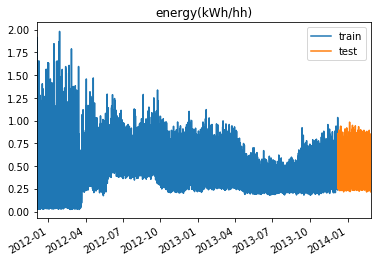

In [12]:
df_train['energy(kWh/hh)'].plot(label='train')
df_test['energy(kWh/hh)'].plot(label='test')
plt.title('energy(kWh/hh)')
plt.legend()

# Plot helpers

In [13]:
def plot_functions(target_x, target_y, context_x, context_y, pred_y, std, undo_log=use_logy, legend=False):
    """Plots the predicted mean and variance and the context points.
  
  Args: 
    target_x: An array of shape [B,num_targets,1] that contains the
        x values of the target points.
    target_y: An array of shape [B,num_targets,1] that contains the
        y values of the target points.
    context_x: An array of shape [B,num_contexts,1] that contains 
        the x values of the context points.
    context_y: An array of shape [B,num_contexts,1] that contains 
        the y values of the context points.
    pred_y: An array of shape [B,num_targets,1] that contains the
        predicted means of the y values at the target points in target_x.
    std: An array of shape [B,num_targets,1] that contains the
        predicted std dev of the y values at the target points in target_x.
      """
    if undo_log:
        target_y=np.exp(target_y)-eps
        context_y=np.exp(context_y)-eps
    # Plot everything 
    # Note: days is first feature in x, since we made sure of that in the dataloader)
    j=0
    
    plt.plot(target_x[0,:,j], target_y[0], 'k:', linewidth=2, label='true')
    plt.plot(context_x[0,:,j], context_y[0], 'ko', markersize=6, label='input data')
    ylims=plt.ylim()
    plt.plot(target_x[0,:,j], pred_y[0], 'b', linewidth=2, label='predicted')
    plt.fill_between(
          target_x[0, :, j],
          pred_y[0, :, 0] - std[0, :, 0],
          pred_y[0, :, 0] + std[0, :, 0],
          alpha=0.25,
          facecolor='blue',
          interpolate=True,
    label='uncertainty')

    # Make the plot pretty
    plt.grid('off')
    plt.ylim(*ylims)
    plt.xlabel('Days')
    plt.ylabel('Energy (kWh/hh)')
    plt.grid(b=None)
    if legend:
        plt.legend()
    ax = plt.gca()
    plt.show()

In [14]:
def plot_from_loader(loader, i=0, undo_log=use_logy, title='', plot=True, legend=False):
    data = loader.collate_fn([loader.dataset[i]])
    data = [d.to(device) for d in data]
    context_x, context_y, target_x, target_y = data

    model.eval()
    with torch.no_grad():
        y_pred, kl, loss_test, y_std = model(context_x, context_y, target_x, target_y)

        if plot:
            plt.title(title+f" loss={loss_test: 2.2g}")
            plot_functions(target_x.detach().cpu().numpy(),
                            target_y.detach().cpu().numpy(),
                            context_x.detach().cpu().numpy(),
                            context_y.detach().cpu().numpy(),
                            y_pred.detach().cpu().numpy(),
                            y_std.detach().cpu().numpy(), undo_log=undo_log, legend=legend)
    return loss_test

# Dataloaders

In [15]:
data_train = SmartMeterDataSet(df_train, num_context, num_extra_target)
data_test = SmartMeterDataSet(df_test, num_context, num_extra_target)

In [16]:
loader_train = torch.utils.data.DataLoader(data_train, batch_size=batch_size, shuffle=True, 
    collate_fn=collate_fns(num_context, num_extra_target, sample=True),
    num_workers=num_workers,
)

loader_test = torch.utils.data.DataLoader(data_test, batch_size=batch_size, shuffle=False, 
    collate_fn=collate_fns(num_context, num_extra_target, sample=False)
)

# Run

In [17]:
x, y, _, _ = next(iter(loader_train))
x.shape, y.shape

(torch.Size([32, 118, 16]), torch.Size([32, 118, 1]))

In [18]:
from src.models.model import LatentModel
model = LatentModel(
    x_dim=x.shape[-1], 
    y_dim=y.shape[-1], 
    hidden_dim=64, 
    latent_dim=64*2,
    dropout=0.5,
    attention_dropout=0,
    num_heads=8,
    n_latent_encoder_layers=6,
    n_det_encoder_layers=6,
    n_decoder_layers=6,
    latent_enc_self_attn_type="multihead", 
    det_enc_self_attn_type="multihead",
    det_enc_cross_attn_type="multihead"
).to(device)

optim = torch.optim.AdamW(model.parameters(), lr=1e-3)

In [19]:
from torchsummaryX import summary
data = next(iter(loader_train))
data = [d.to(device) for d in data]
context_x, context_y, target_x, target_y = data
with torch.no_grad():
    model.eval()
    summary(model, context_x, context_y, target_x, target_y)
    dist, log_p, kl, loss = model(context_x, context_y, target_x, target_y)

                                                   Kernel Shape       Output Shape   Params Mult-Adds
Layer                                                                                                
0__latent_encoder._input_layer.Linear_linear           [17, 64]      [32, 118, 64]   1.152k    1.088k
1__latent_encoder._input_layer.ReLU_act                       -      [32, 118, 64]        -         -
2__latent_encoder._input_layer.BatchNorm2d_norm            [64]   [32, 64, 118, 1]    128.0      64.0
3__latent_encoder._input_layer.Dropout2d_dropout              -   [32, 64, 118, 1]        -         -
4__latent_encoder._encoder.0.Linear_linear             [64, 64]      [32, 118, 64]    4.16k    4.096k
5__latent_encoder._encoder.0.ReLU_act                         -      [32, 118, 64]        -         -
6__latent_encoder._encoder.0.BatchNorm2d_norm              [64]   [32, 64, 118, 1]    128.0      64.0
7__latent_encoder._encoder.0.Dropout2d_dropout                -   [32, 64, 118, 1]

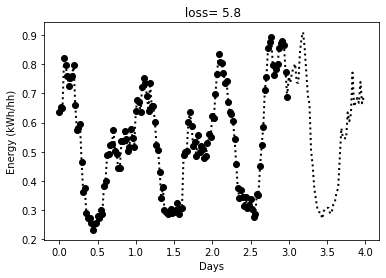

tensor(5.8293, device='cuda:0')

In [20]:
# Lets choose a challenging time to forecast
vis_i = 690 # 290 # 1600
plot_from_loader(loader_test, i=690)

0, i=0, loss: 20.88, test: 5.521, grad_norm:  5e+02, std:  0.22
0, i=100, loss: 2.342, test: 0.7096, grad_norm:  17, std:  2.5e+04
0, i=200, loss: 1.312, test: 0.5547, grad_norm:  19, std:  17
0, i=300, loss: 0.4696, test: 0.1703, grad_norm:  12, std:  89
0, i=400, loss: 0.3346, test: -0.142, grad_norm:  24, std:  0.27
0, i=500, loss: -0.0977, test: -0.0574, grad_norm:  11, std:  0.7
0, i=600, loss: 0.001698, test: -0.01503, grad_norm:  20, std:  37
0, i=700, loss: 0.1529, test: -0.004121, grad_norm:  30, std:  20
0, i=800, loss: -0.214, test: 0.1508, grad_norm:  16, std:  1.8e+05
0, i=900, loss: -0.29, test: -0.3524, grad_norm:  15, std:  0.42
0, i=1000, loss: -0.332, test: -0.5467, grad_norm:  7.2, std:  0.33


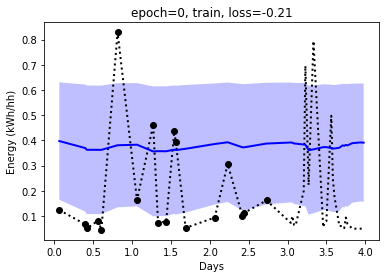

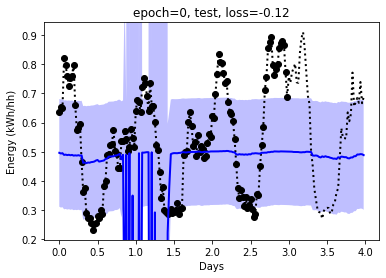

epoch: 0, loss: -0.4959, loss_test:-0.1215, kl=-0.7, grad_norm:  14


1, i=0, loss: -0.4882, test: -0.122, grad_norm:  5.5, std:  1e+02
1, i=100, loss: -0.3862, test: -0.6748, grad_norm:  6.4, std:  0.28
1, i=200, loss: -0.8076, test: -0.6587, grad_norm:  5.9, std:  4.2e+04
1, i=300, loss: -0.7484, test: -0.8384, grad_norm:  12, std:  1.1e+05
1, i=400, loss: -0.9018, test: -0.9439, grad_norm:  5.8, std:  0.96
ERROR:smartmeters.ipynb:grad_norm is not finite
1, i=500, loss: -0.6739, test:   -1, grad_norm:  41, std:  0.24
ERROR:smartmeters.ipynb:grad_norm is not finite
1, i=600, loss: -1.198, test: -1.228, grad_norm:  5.1, std:  4.2e+04
1, i=700, loss: -1.065, test: -1.109, grad_norm:  9.1, std:  0.21
1, i=800, loss:   -1, test: -1.185, grad_norm:  11, std:  0.76
ERROR:smartmeters.ipynb:grad_norm is not finite
ERROR:smartmeters.ipynb:grad_norm is not finite
1, i=900, loss: -1.169, test: -1.226, grad_norm:  5.7, std:  0.43
1, i=1000, loss: -0.9886, test: -1.225, grad_norm:  12, std:  0.3


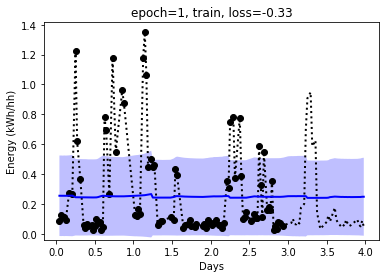

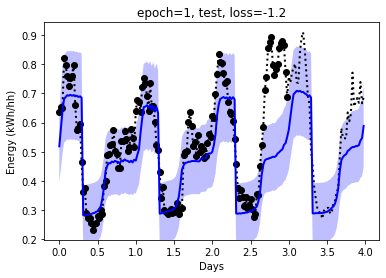

epoch: 1, loss: -1.671, loss_test:-1.161, kl=-1, grad_norm:  34


2, i=0, loss: -0.9738, test: -1.111, grad_norm:  6, std:  0.38
2, i=100, loss: -1.187, test: -1.188, grad_norm:  9.6, std:  0.22
2, i=200, loss: -1.116, test: -1.217, grad_norm:  7.8, std:  0.19
2, i=300, loss: -1.158, test: -1.181, grad_norm:  12, std:  0.17
2, i=400, loss: -0.8773, test: -1.114, grad_norm:  8.2, std:  0.32
2, i=500, loss: -1.244, test: -1.224, grad_norm:  4.7, std:  2e+07
2, i=600, loss: -1.17, test: -1.132, grad_norm:  8.4, std:  0.15
2, i=700, loss: -1.383, test: -1.231, grad_norm:  11, std:  0.13
2, i=800, loss: -1.025, test: -1.379, grad_norm:  11, std:  0.21
2, i=900, loss: -0.9396, test: -1.294, grad_norm:  8.5, std:  0.22
2, i=1000, loss: -1.192, test: -1.458, grad_norm:  16, std:  0.14


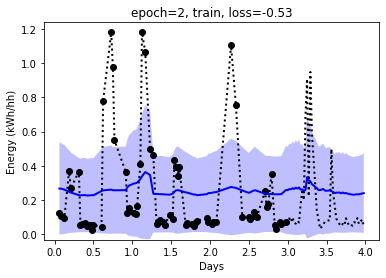

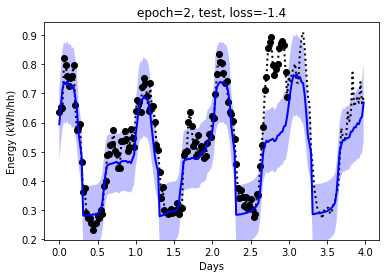

epoch: 2, loss: -1.081, loss_test:-1.415, kl=-0.53, grad_norm:  27


3, i=0, loss: -1.408, test: -1.413, grad_norm:  8.8, std:  0.17
3, i=100, loss: -1.367, test: -1.484, grad_norm:  10, std:  0.2
3, i=200, loss: -1.287, test: -1.45, grad_norm:  8.8, std:  0.17
3, i=300, loss: -0.8809, test: -1.405, grad_norm:  17, std:  0.18
3, i=400, loss: -1.272, test: -1.461, grad_norm:  7.8, std:  0.16
3, i=500, loss: -1.348, test: -1.2, grad_norm:  10, std:  0.18
3, i=600, loss: -1.433, test: -1.29, grad_norm:  8.1, std:  0.16
3, i=700, loss: -1.16, test: -1.274, grad_norm:  5.3, std:  0.75
3, i=800, loss: -1.253, test: -1.419, grad_norm:  11, std:  0.16
3, i=900, loss: -1.239, test: -1.445, grad_norm:  11, std:  0.15
3, i=1000, loss: -1.354, test: -1.366, grad_norm:  6.3, std:  0.14


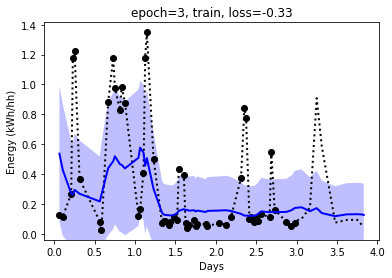

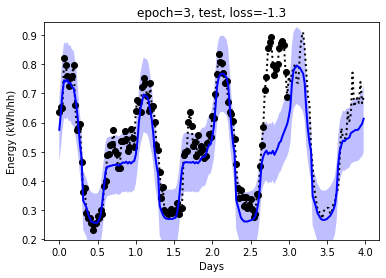

epoch: 3, loss: -1.287, loss_test:-1.325, kl=-0.38, grad_norm:  8.2


4, i=0, loss: -1.184, test: -1.341, grad_norm:  12, std:  0.14
4, i=100, loss: -1.559, test: -1.33, grad_norm:  6.7, std:  0.14
4, i=200, loss: -1.405, test: -1.529, grad_norm:  5, std:  0.21
4, i=300, loss: -1.108, test: -1.251, grad_norm:  8.7, std:  0.15
4, i=400, loss: -1.228, test: -1.33, grad_norm:  6.7, std:  0.14
4, i=500, loss: -1.029, test: -1.285, grad_norm:  4.1, std:  0.16
4, i=600, loss: -1.267, test: -1.297, grad_norm:  6, std:  0.16
4, i=700, loss: -0.9522, test: -1.251, grad_norm:  9, std:  0.14
4, i=800, loss: -1.213, test: -1.436, grad_norm:  9.6, std:  0.13
4, i=900, loss: -1.287, test: -1.42, grad_norm:  7.4, std:  0.13
4, i=1000, loss: -1.396, test: -1.372, grad_norm:  7.8, std:  0.15


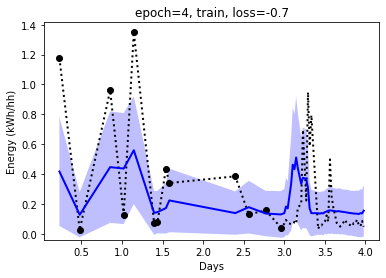

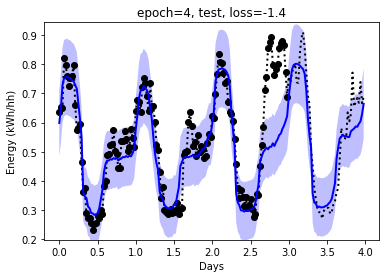

epoch: 4, loss: -1.387, loss_test:-1.406, kl=-0.56, grad_norm:  13


5, i=0, loss: -1.354, test: -1.395, grad_norm:  13, std:  0.13
5, i=100, loss: -1.348, test: -1.382, grad_norm:  4.1, std:  0.21
5, i=200, loss: -1.428, test: -1.322, grad_norm:  4.5, std:  0.34
5, i=300, loss: -1.145, test: -1.331, grad_norm:  7.6, std:  0.14
5, i=400, loss: -1.369, test: -1.315, grad_norm:  3.4, std:  0.14
5, i=500, loss: -1.183, test: -1.192, grad_norm:  6.4, std:  0.13
5, i=600, loss: -1.269, test: -1.374, grad_norm:  4.3, std:  0.14
5, i=700, loss: -1.243, test: -1.352, grad_norm:  6.8, std:  1.3e+02
5, i=800, loss: -1.338, test: -1.31, grad_norm:  10, std:  0.52
5, i=900, loss: -0.9873, test: -1.399, grad_norm:  10, std:  0.14
5, i=1000, loss: -1.353, test: -1.355, grad_norm:  6.4, std:  0.13


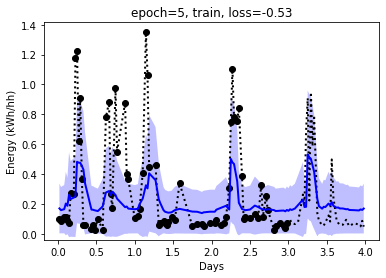

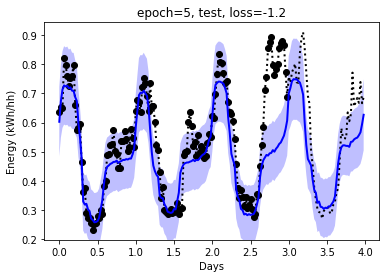

epoch: 5, loss: -1.358, loss_test:-1.23, kl=-0.7, grad_norm:  14


6, i=0, loss: -1.137, test: -1.246, grad_norm:  3.1, std:  0.14
6, i=100, loss: -1.246, test: -1.231, grad_norm:  7.6, std:  0.12
6, i=200, loss: -1.207, test: -1.216, grad_norm:  4.3, std:  0.36
6, i=300, loss: -1.208, test: -1.14, grad_norm:  8.9, std:  0.15
6, i=400, loss: -1.302, test: -1.08, grad_norm:  10, std:  0.13
6, i=500, loss: -1.452, test: -1.211, grad_norm:  5.6, std:  0.49
6, i=600, loss: -1.373, test: -1.268, grad_norm:  9.1, std:  0.14
6, i=700, loss: -1.48, test: -1.304, grad_norm:  3.3, std:  0.14
6, i=800, loss: -1.262, test: -1.309, grad_norm:  7.4, std:  1
6, i=900, loss: -1.408, test: -1.404, grad_norm:  4.9, std:  0.13
6, i=1000, loss: -1.442, test: -1.244, grad_norm:  8.7, std:  0.12


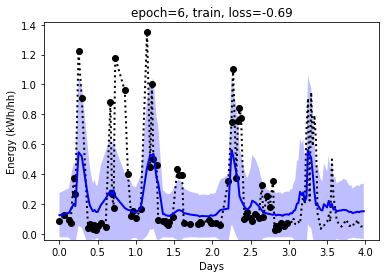

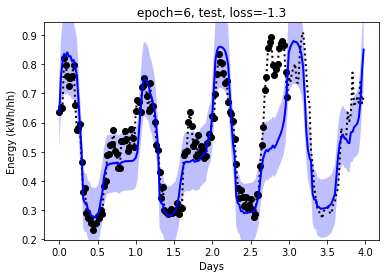

epoch: 6, loss: -1.45, loss_test:-1.295, kl=-0.75, grad_norm:  16


7, i=0, loss: -1.447, test: -1.301, grad_norm:  7.8, std:  0.17
7, i=100, loss: -1.233, test: -1.349, grad_norm:  7.4, std:  0.14
7, i=200, loss: -1.121, test: -1.357, grad_norm:  3.6, std:  0.13
7, i=300, loss: -1.593, test: -1.331, grad_norm:  7.2, std:  0.13
7, i=400, loss: -1.207, test: -1.291, grad_norm:  10, std:  0.13
7, i=500, loss: -1.312, test: -1.43, grad_norm:  6.7, std:  0.14
7, i=600, loss: -1.544, test: -1.382, grad_norm:  5, std:  0.13
7, i=700, loss: -1.316, test: -1.358, grad_norm:  3.8, std:  0.2
7, i=800, loss: -1.657, test: -1.429, grad_norm:  3.7, std:  0.13
7, i=900, loss: -1.356, test: -1.368, grad_norm:  5.4, std:  0.12
7, i=1000, loss: -0.9673, test: -1.373, grad_norm:  4.8, std:  0.14


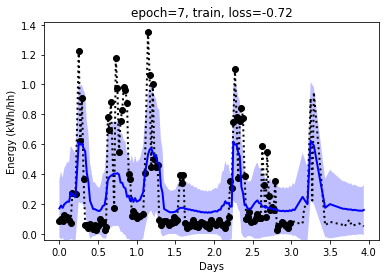

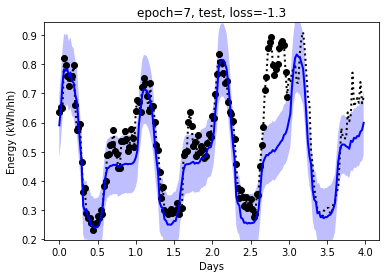

epoch: 7, loss: -1.333, loss_test:-1.283, kl=-0.5, grad_norm:  17


8, i=0, loss: -1.559, test: -1.249, grad_norm:  3.8, std:  0.13
8, i=100, loss: -1.246, test: -1.328, grad_norm:  6.7, std:  0.13
8, i=200, loss: -1.54, test: -1.333, grad_norm:  7.1, std:  0.13
8, i=300, loss: -1.288, test: -1.344, grad_norm:  5.9, std:  23
8, i=400, loss: -1.517, test: -1.327, grad_norm:  5.7, std:  0.14
8, i=500, loss: -1.367, test: -1.285, grad_norm:  18, std:  0.15
8, i=600, loss: -1.477, test: -1.345, grad_norm:  5.2, std:  0.12
8, i=700, loss: -1.303, test: -1.401, grad_norm:  5.2, std:  0.12
8, i=800, loss: -1.286, test: -1.381, grad_norm:  10, std:  0.13
8, i=900, loss: -1.238, test: -1.4, grad_norm:  8.4, std:  0.13
8, i=1000, loss: -1.578, test: -1.363, grad_norm:  7.6, std:  0.12


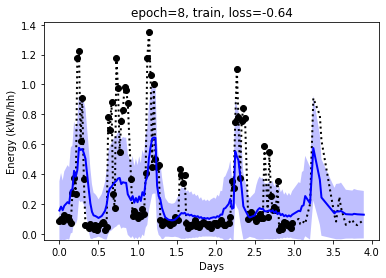

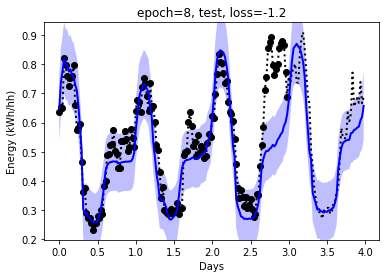

epoch: 8, loss: -1.219, loss_test:-1.197, kl=-0.49, grad_norm:  8.2


9, i=0, loss: -1.391, test: -1.214, grad_norm:  2.4, std:  0.12
9, i=100, loss: -1.014, test: -1.185, grad_norm:  5.6, std:  0.14
9, i=200, loss: -1.196, test: -1.165, grad_norm:  2.7, std:  0.12
9, i=300, loss: -1.394, test: -1.031, grad_norm:  4.2, std:  0.13
9, i=400, loss: -1.395, test: -0.9419, grad_norm:  3.1, std:  0.13
9, i=500, loss: -1.25, test: -0.9631, grad_norm:  8.6, std:  0.12
9, i=600, loss: -1.408, test: -1.03, grad_norm:  4.7, std:  0.13
9, i=700, loss: -1.351, test: -0.9259, grad_norm:  4.3, std:  0.14
9, i=800, loss: -1.455, test: -0.97, grad_norm:  2.6, std:  0.11
9, i=900, loss: -1.189, test: -1.286, grad_norm:  5, std:  0.12
9, i=1000, loss: -1.236, test: -1.183, grad_norm:  6.9, std:  0.14


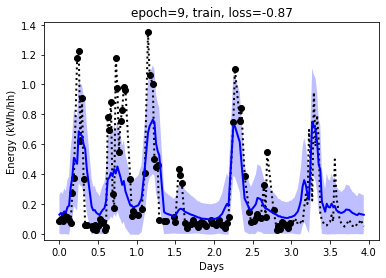

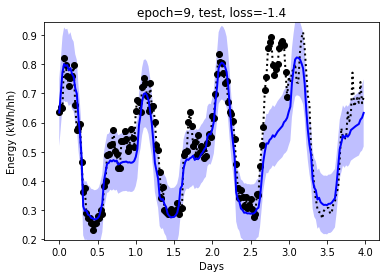

epoch: 9, loss: -1.114, loss_test:-1.4, kl=-0.48, grad_norm:  18


10, i=0, loss: -1.453, test: -1.356, grad_norm:  5.5, std:  0.12
10, i=100, loss: -1.27, test: -1.3, grad_norm:  5.5, std:  0.13
10, i=200, loss: -1.263, test: -1.347, grad_norm:  8.4, std:  0.13
10, i=300, loss: -1.061, test: -1.367, grad_norm:  8.2, std:  0.13
10, i=400, loss: -1.462, test: -1.404, grad_norm:  9.1, std:  0.14
10, i=500, loss: -1.099, test: -1.416, grad_norm:  9.9, std:  0.15
10, i=600, loss: -1.663, test: -1.263, grad_norm:  4.1, std:  0.12
10, i=700, loss: -1.228, test: -1.369, grad_norm:  8.6, std:  0.11
10, i=800, loss: -1.301, test: -1.391, grad_norm:  2.5, std:  0.12
10, i=900, loss: -1.292, test: -1.358, grad_norm:  6.1, std:  0.12
10, i=1000, loss: -1.563, test: -1.32, grad_norm:  3.8, std:  0.12


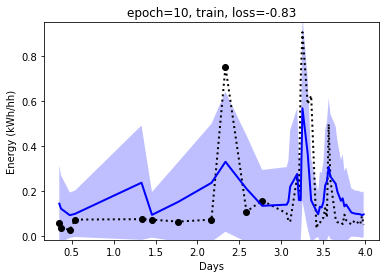

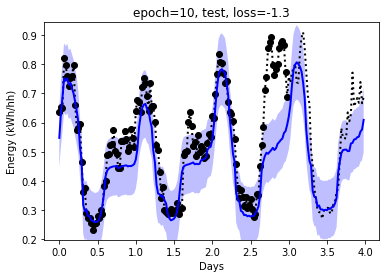

epoch: 10, loss: -1.083, loss_test:-1.259, kl=-0.26, grad_norm:  7.8


11, i=0, loss: -1.456, test: -1.268, grad_norm:  3.6, std:  0.12
11, i=100, loss: -1.184, test: -1.369, grad_norm:  3.1, std:  0.14
11, i=200, loss: -1.387, test: -1.431, grad_norm:  3.8, std:  0.13
11, i=300, loss: -1.253, test: -1.475, grad_norm:  13, std:  0.13
11, i=400, loss: -1.44, test: -1.428, grad_norm:  8.1, std:  0.12
11, i=500, loss: -1.25, test: -1.498, grad_norm:  2.9, std:  0.13
11, i=600, loss: -1.448, test: -1.524, grad_norm:  3.1, std:  0.13
11, i=700, loss: -1.378, test: -1.362, grad_norm:  1.9, std:  0.13
11, i=800, loss: -1.517, test: -1.54, grad_norm:  7.9, std:  0.12
11, i=900, loss: -1.36, test: -1.509, grad_norm:  3.4, std:  0.14
11, i=1000, loss: -1.552, test: -1.388, grad_norm:  6.2, std:  0.13


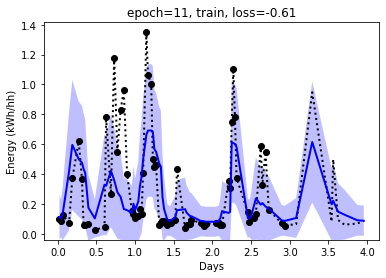

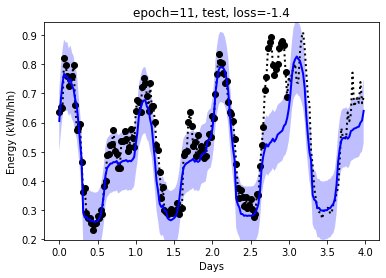

epoch: 11, loss: -1.362, loss_test:-1.398, kl=-0.57, grad_norm:  5.1


12, i=0, loss: -1.476, test: -1.4, grad_norm:  3.3, std:  0.13
12, i=100, loss: -1.48, test: -1.483, grad_norm:  7, std:  0.12
12, i=200, loss: -1.275, test: -1.357, grad_norm:  3.1, std:  0.13
12, i=300, loss: -1.142, test: -1.38, grad_norm:  4.8, std:  0.13
12, i=400, loss: -1.505, test: -1.402, grad_norm:  3.6, std:  0.14
12, i=500, loss: -1.516, test: -1.348, grad_norm:  1.9, std:  0.14
12, i=600, loss: -1.413, test: -1.435, grad_norm:  1.9, std:  0.13
12, i=700, loss: -1.305, test: -1.316, grad_norm:  9.5, std:  0.12
12, i=800, loss: -1.68, test: -1.326, grad_norm:  2.2, std:  0.12
12, i=900, loss: -1.484, test: -1.377, grad_norm:  3.1, std:  0.13
12, i=1000, loss: -1.331, test: -1.503, grad_norm:  1.9, std:  0.13


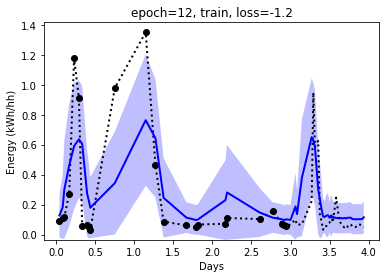

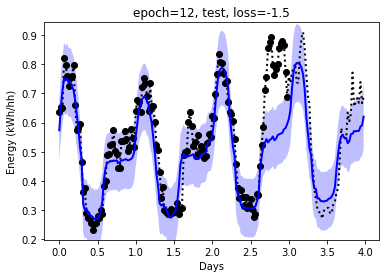

epoch: 12, loss: -1.073, loss_test:-1.468, kl=-0.52, grad_norm:  8


13, i=0, loss: -1.545, test: -1.489, grad_norm:  4.5, std:  0.13
13, i=100, loss: -1.168, test: -1.541, grad_norm:  4.1, std:  0.13
13, i=200, loss: -1.482, test: -1.381, grad_norm:  2.4, std:  0.12
13, i=300, loss: -1.393, test: -1.436, grad_norm:  2.9, std:  0.12
13, i=400, loss: -1.368, test: -1.325, grad_norm:  1.6, std:  0.13
13, i=500, loss: -1.409, test: -1.419, grad_norm:  3.1, std:  0.15
13, i=600, loss: -1.306, test: -1.416, grad_norm:  2.5, std:  0.13
13, i=700, loss: -1.154, test: -1.368, grad_norm:  7.4, std:  0.12
13, i=800, loss: -1.276, test: -1.34, grad_norm:  2.3, std:  0.13
13, i=900, loss: -1.347, test: -1.373, grad_norm:  2.8, std:  0.12
13, i=1000, loss: -1.181, test: -1.379, grad_norm:  8.3, std:  0.11


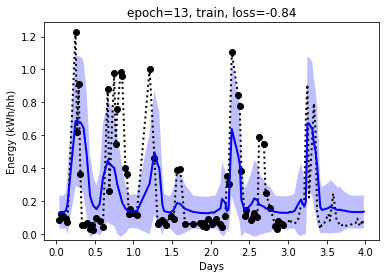

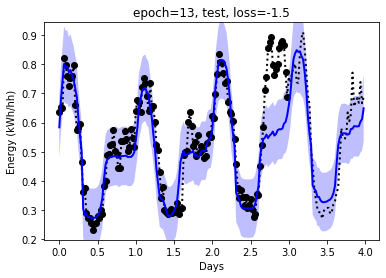

epoch: 13, loss: -1.08, loss_test:-1.452, kl=-0.34, grad_norm:  8.8


14, i=0, loss: -1.458, test: -1.468, grad_norm:  2.6, std:  0.13
14, i=100, loss: -1.507, test: -1.562, grad_norm:  4.7, std:  0.12
14, i=200, loss: -1.529, test: -1.546, grad_norm:  5, std:  0.12
14, i=300, loss: -1.458, test: -1.471, grad_norm:  4.3, std:  0.13
14, i=400, loss: -1.325, test: -1.348, grad_norm:  2.8, std:  0.13
14, i=500, loss: -1.293, test: -1.368, grad_norm:  2.5, std:  0.12
14, i=600, loss: -1.485, test: -1.39, grad_norm:  2.9, std:  0.13
14, i=700, loss: -1.08, test: -1.389, grad_norm:  4.2, std:  0.13
14, i=800, loss: -1.347, test: -1.425, grad_norm:  2.7, std:  0.13
14, i=900, loss: -1.506, test: -1.475, grad_norm:  1.7, std:  0.12
14, i=1000, loss: -1.584, test: -1.369, grad_norm:  4.4, std:  0.12


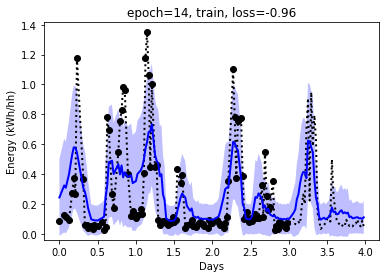

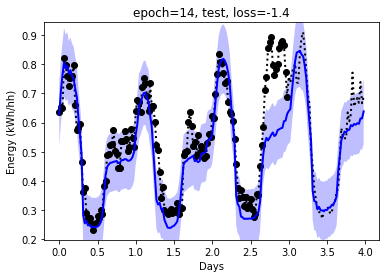

epoch: 14, loss: -1.623, loss_test:-1.359, kl=-0.6, grad_norm:  5.6


15, i=0, loss: -1.421, test: -1.326, grad_norm:  2.2, std:  0.12
15, i=100, loss: -1.227, test: -1.364, grad_norm:  5.6, std:  0.12
15, i=200, loss: -1.479, test: -1.438, grad_norm:  1.5, std:  0.11
15, i=300, loss: -1.409, test: -1.523, grad_norm:  2.2, std:  0.12
15, i=400, loss: -1.439, test: -1.391, grad_norm:  3.2, std:  0.12
15, i=500, loss: -1.535, test: -1.361, grad_norm:  2.4, std:  0.12
15, i=600, loss: -1.388, test: -1.301, grad_norm:  9.2, std:  0.13
15, i=700, loss: -1.246, test: -1.236, grad_norm:  7.2, std:  0.15
15, i=800, loss: -1.566, test: -1.408, grad_norm:  2.7, std:  0.13
15, i=900, loss: -1.26, test: -1.46, grad_norm:  1.6, std:  0.12
15, i=1000, loss: -1.405, test: -1.406, grad_norm:  7.6, std:  0.13


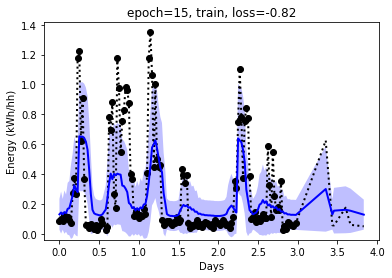

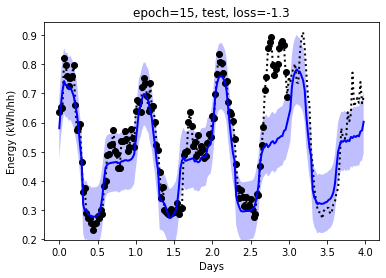

epoch: 15, loss: -1.511, loss_test:-1.334, kl=-0.66, grad_norm:  11


16, i=0, loss: -1.383, test: -1.351, grad_norm:  4, std:  0.15
16, i=100, loss: -1.448, test: -1.448, grad_norm:  7.4, std:  0.12
16, i=200, loss: -1.385, test: -1.496, grad_norm:  2.3, std:  0.12
16, i=300, loss: -1.403, test: -1.476, grad_norm:  5.1, std:  0.13
16, i=400, loss: -1.085, test: -1.408, grad_norm:  3.2, std:  0.13
16, i=500, loss: -1.349, test: -1.403, grad_norm:  4.8, std:  0.13
16, i=600, loss: -1.459, test: -1.418, grad_norm:  2.7, std:  0.13
16, i=700, loss: -1.408, test: -1.273, grad_norm:  2.9, std:  0.12
16, i=800, loss: -1.424, test: -1.525, grad_norm:  4.3, std:  0.14
16, i=900, loss: -1.486, test: -1.422, grad_norm:  2.9, std:  0.13
16, i=1000, loss: -1.166, test: -1.499, grad_norm:  4.9, std:  0.12


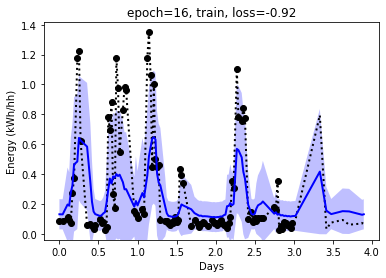

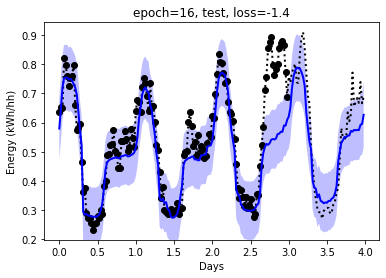

epoch: 16, loss: -1.462, loss_test:-1.41, kl=-0.48, grad_norm:  4.2


17, i=0, loss: -1.498, test: -1.42, grad_norm:  1.7, std:  0.12
17, i=100, loss: -1.055, test: -1.454, grad_norm:  5.4, std:  0.15
17, i=200, loss: -1.516, test: -1.32, grad_norm:  1.6, std:  0.12
17, i=300, loss: -1.406, test: -1.437, grad_norm:  4.9, std:  0.13
17, i=400, loss: -1.3, test: -1.461, grad_norm:  6.7, std:  0.13
17, i=500, loss: -1.254, test: -1.468, grad_norm:  2.3, std:  0.13
17, i=600, loss: -1.585, test: -1.498, grad_norm:  1.5, std:  0.13
17, i=700, loss: -1.329, test: -1.508, grad_norm:  6.9, std:  0.12
17, i=800, loss: -1.567, test: -1.471, grad_norm:  1.4, std:  0.12
17, i=900, loss: -1.396, test: -1.496, grad_norm:  2.4, std:  0.11
17, i=1000, loss: -1.542, test: -1.435, grad_norm:  8.2, std:  0.12


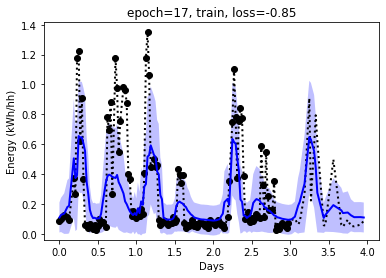

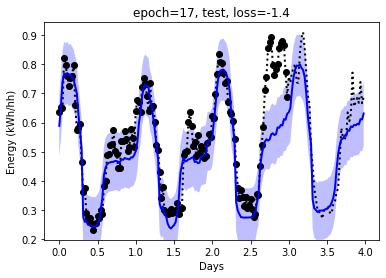

epoch: 17, loss: -1.167, loss_test:-1.433, kl=-0.37, grad_norm:  12


18, i=0, loss: -1.271, test: -1.442, grad_norm:  3.1, std:  0.13
18, i=100, loss: -1.621, test: -1.384, grad_norm:  1.4, std:  0.11
18, i=200, loss: -1.137, test: -0.7458, grad_norm:  6.2, std:  0.13
18, i=300, loss: -1.599, test: -1.441, grad_norm:  1.6, std:  0.11
18, i=400, loss: -1.532, test: -1.452, grad_norm:  1.8, std:  0.12
18, i=500, loss: -1.617, test: -1.353, grad_norm:  2.2, std:  0.12
18, i=600, loss: -1.455, test: -1.444, grad_norm:  2, std:  0.12
18, i=700, loss: -1.464, test: -1.451, grad_norm:  1.9, std:  0.12
18, i=800, loss: -1.41, test: -1.321, grad_norm:  3.7, std:  0.14
18, i=900, loss: -1.507, test: -1.379, grad_norm:  1.4, std:  0.12
18, i=1000, loss: -1.356, test: -1.316, grad_norm:  1.7, std:  0.12


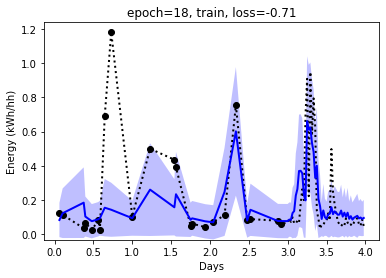

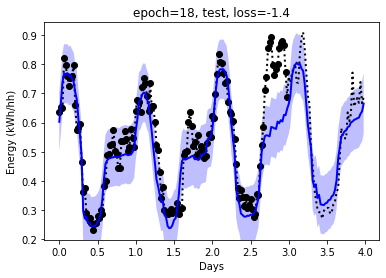

epoch: 18, loss: -1.431, loss_test:-1.364, kl=-0.54, grad_norm:  14


19, i=0, loss: -1.324, test: -1.368, grad_norm:  3.3, std:  0.14
19, i=100, loss: -1.25, test: -1.304, grad_norm:  2.9, std:  0.12
19, i=200, loss: -1.054, test: -0.8624, grad_norm:  5.5, std:  0.15
19, i=300, loss: -1.547, test: -1.375, grad_norm:  1.3, std:  0.13
19, i=400, loss: -1.417, test: -1.38, grad_norm:  2.6, std:  0.13
19, i=500, loss: -1.341, test: -1.418, grad_norm:  1.7, std:  0.12
19, i=600, loss: -1.384, test: -1.34, grad_norm:  8.7, std:  0.12
19, i=700, loss: -1.217, test: -1.468, grad_norm:  7.7, std:  0.14
19, i=800, loss: -1.38, test: -1.364, grad_norm:  2.5, std:  0.13
19, i=900, loss: -1.359, test: -1.442, grad_norm:  6.1, std:  0.12
19, i=1000, loss: -1.102, test: -1.461, grad_norm:  5.5, std:  0.15


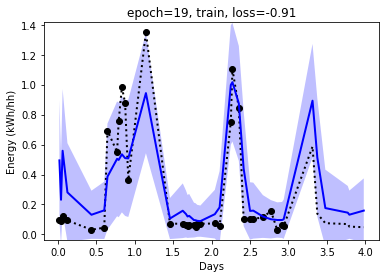

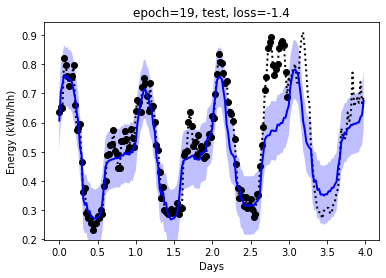

epoch: 19, loss: -1.669, loss_test:-1.414, kl=-0.69, grad_norm:  4.3



In [21]:
epochs = 20
grad_clip = 10
history = []
for epoch in tqdm(range(epochs), unit='epoch'):

    pbar = tqdm(loader_train, unit='batch')
    for i, data in enumerate(pbar):
        model.train()
        assert all(torch.isfinite(d).all() for d in data)
        data = [d.to(device) for d in data]
        context_x, context_y, target_x, target_y = data

        optim.zero_grad()
        y_pred, kl, loss, y_std = model(context_x, context_y, target_x, target_y)

        # These attentive NP models work great when you need uncertainty, but still seem a bit unstable. 
        # Sometimes they produce nans, especically if the data is not fully normalized. 
        assert torch.isfinite(y_pred.sum())
        if not torch.isfinite(loss):
            logger.error("loss is not finite")
            continue
        loss.backward()
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
        if not np.isfinite(grad_norm):
            logger.error("grad_norm is not finite")
            continue
        optim.step()

        if i%100==0:
            model.eval()
            test_loss = plot_from_loader(loader_test, i=vis_i, plot=False)
            pbar.set_description(f"{epoch}, loss: {loss.item():4.4g}, test: {test_loss.item():4.4g}")
            print(f"{epoch}, i={i}, loss: {loss.item():4.4g}, test: {test_loss.item():4.4g}, grad_norm: {grad_norm: 2.2g}, std: {y_std.mean().item(): 2.2g}")
            
            history.append(dict(
                n=epoch*len(loader_train) + i,
                epoch=epoch,
                i=i,
                loss=loss.item(),
                kl=kl.mean().item(),
                test_loss=test_loss.item(),
                y_std=y_std.mean().item(),
                grad_norm=grad_norm,
            ))
        
    test_loss = plot_from_loader(loader_train, i=vis_i, title=f'epoch={epoch}, train,')
    model.eval()
    test_loss = plot_from_loader(loader_test, i=vis_i, title=f'epoch={epoch}, test,')
    print(f"epoch: {epoch}, loss: {loss.item():4.4g}, loss_test:{test_loss.item():4.4g}, kl={kl.mean().item():2.2g}, grad_norm: {grad_norm: 2.2g}")

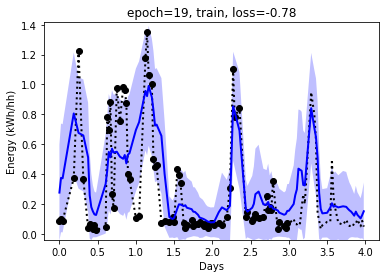

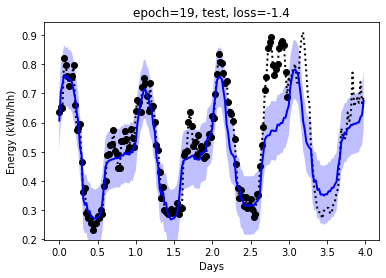

In [36]:
test_loss = plot_from_loader(loader_train, i=vis_i, title=f'epoch={epoch}, train,')
model.eval()
test_loss = plot_from_loader(loader_test, i=vis_i, title=f'epoch={epoch}, test,')

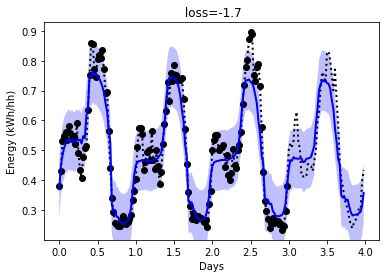

tensor(-1.6955, device='cuda:0')

In [23]:
plot_from_loader(loader_test)

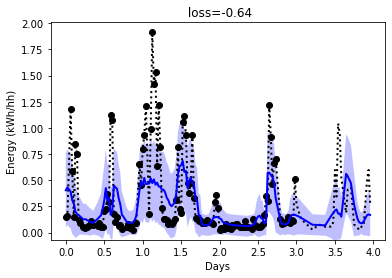

tensor(-0.6384, device='cuda:0')

In [35]:
plot_from_loader(loader_train)

## History

In [25]:
df_hist = pd.DataFrame(history)
df_hist['n'] = df_hist['n']/(df_hist['epoch']+1)
df_hist.head(3)

,epoch,grad_norm,i,kl,loss,n,test_loss,y_std
0,0,502.629333,0,4.846100,20.881706,0.0,5.520771,0.221431
1,0,17.492069,100,2.056377,2.341762,100.0,0.709551,25024.410156
2,0,18.713187,200,1.205957,1.312163,200.0,0.554707,16.598171


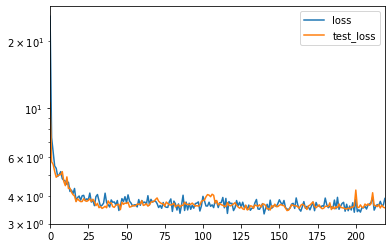

In [29]:
(df_hist[['loss', 'test_loss']]+5).plot(logy=True)

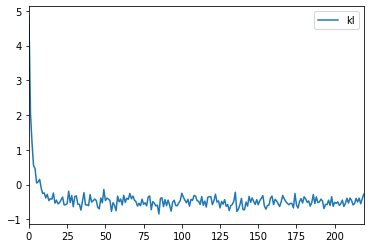

In [27]:
df_hist[['kl']].plot()

/home/wassname/.pyenv/versions/3.7.2/envs/jup3.7.2/lib/python3.7/site-packages/pandas/plotting/_core.py:441: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_ylim(self.ylim)


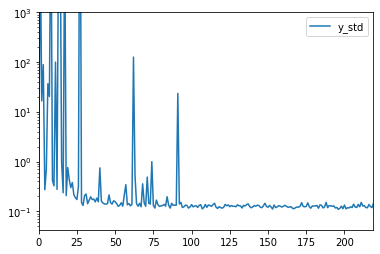

In [28]:
df_hist[['y_std']].plot(ylim=[0,1e3], logy=True)